https://networkrepository.com/karate.php

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

Number of nodes: 19
Number of edges: 29
Is connected: True


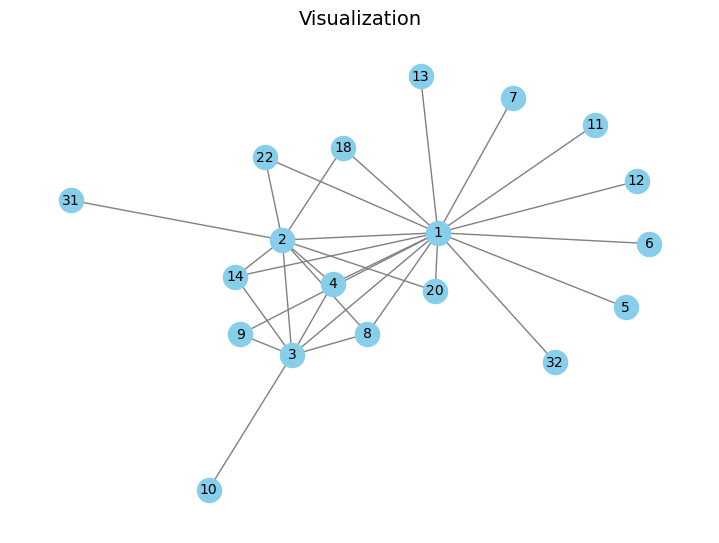

In [12]:

G = nx.read_edgelist('soc_karate.txt', delimiter=',', nodetype=int)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is connected:", nx.is_connected(G))
plt.figure(figsize=(7, 5))
nx.draw(G, nx.spring_layout(G, seed=0), with_labels=True, node_size=300, node_color='skyblue', edge_color='gray', font_size=10)
plt.title("Visualization", fontsize=14)
plt.axis('off')
plt.show()

